In [ ]:
import re
from collections import defaultdict
import numpy as np
import pandas as pd
from pymatgen.core.periodic_table import Specie, Element
from mendeleev.fetch import fetch_table
from mendeleev.econf import ElectronicConfiguration

from approximate import ApprOXimate
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# GLOBALS & CONSTANTS
# ==============================
ptable = fetch_table("elements")
DEFAULT_CATION = 'Na'
DEFAULT_ANION = 'O'

# ==============================
# PARSING FUNCTIONS
# ==============================
def parse_formula(formula):
    """Parse chemical formula into {element: amount} dict."""
    pattern = r"([A-Z][a-z]*)([0-9./]*)"
    matches = re.findall(pattern, formula)
    element_amounts = defaultdict(float)

    for element, amount in matches:
        if not amount:
            amount = 1
        elif "/" in amount:  # Handle fractions
            num, den = map(float, amount.split("/"))
            amount = num / den
        else:
            amount = float(amount)
        element_amounts[element] += amount

    return dict(element_amounts)

def parse_approximate_str(data_string):
    """Parse 'Element:Oxidation:Amount;...' into {element: [(ox_state, amount), ...]}."""
    appr_dict = {}
    for entry in data_string.split(";"):
        element, oxidation, amount = entry.split(':')
        ox_state = int(oxidation)
        amount = float(amount)
        appr_dict.setdefault(element, []).append((ox_state, amount))
    return appr_dict

# ==============================
# BASE CALCULATIONS
# ==============================

def cal_avg_weighted_ox(comp_dict):
    """Weighted average oxidation state per element."""
    return {
        el: (
            sum(ox * frac for ox, frac in details) / sum(frac for _, frac in details)
            if len(details) > 1 else details[0][0]
        )
        for el, details in comp_dict.items()
    }

def cal_avg_weighted_ionic_radius(comp_dict):
    """Weighted average ionic radius per element."""
    avg_radii = {}
    for el, details in comp_dict.items():
        if len(details) > 1:
            total = sum(Specie(el, ox).ionic_radius * frac for ox, frac in details)
            frac_sum = sum(frac for _, frac in details)
            avg_radii[el] = total / frac_sum
        else:
            avg_radii[el] = Specie(el, details[0][0]).ionic_radius
    return avg_radii

def cal_weighted_ionic_pot(element, ox_state, frac):
    """Fraction-weighted ionic potential."""
    radius = Specie(element, ox_state).ionic_radius
    return frac * (ox_state / radius)

# ==============================
# CATION/ANION CALCULATIONS
# ==============================
def cal_TM_weighted_ionic_pot(comp_dict, cation=DEFAULT_CATION, anion=DEFAULT_ANION):
    """Total transition metal ionic potential."""
    total = 0
    for el, details in comp_dict.items():
        if el not in (cation, anion):
            for ox, frac in details:
                total += cal_weighted_ionic_pot(el, ox, frac)
    return total

def cal_cat_an_ionic_pot(comp_dict, cation=DEFAULT_CATION, anion=DEFAULT_ANION):
    """Calculate ionic potential for cation and anion."""
    cat_ox, cat_frac = comp_dict[cation][0]
    an_ox, an_frac = comp_dict[anion][0]
    return (
        cal_weighted_ionic_pot(cation, cat_ox, cat_frac),
        -cal_weighted_ionic_pot(anion, an_ox, an_frac)  # anion is negative
    )

def cal_cationic_potential(comp_dict, cation=DEFAULT_CATION, anion=DEFAULT_ANION):
    """Cationic potential from TM ionic potential & cation/anion potentials."""
    TM_pot = cal_TM_weighted_ionic_pot(comp_dict, cation, anion)
    cat_pot, an_pot = cal_cat_an_ionic_pot(comp_dict, cation, anion)
    return (TM_pot * cat_pot) / an_pot

def cal_TM_weighted_ionic_radii(comp_dict, cation=DEFAULT_CATION, anion=DEFAULT_ANION):
    """Weighted average ionic radii of transition metals."""
    total_frac = weighted_sum = 0
    for el, details in comp_dict.items():
        if el not in (cation, anion):
            for ox, frac in details:
                radius = Specie(el, ox).ionic_radius
                weighted_sum += radius * frac
                total_frac += frac
    return weighted_sum / total_frac

def cal_radial_potential(comp_dict, cation=DEFAULT_CATION, anion=DEFAULT_ANION):
    """Radial potential calculation."""
    TM_radii = cal_TM_weighted_ionic_radii(comp_dict, cation, anion)
    cat_pot, an_pot = cal_cat_an_ionic_pot(comp_dict, cation, anion)
    return (TM_radii * cat_pot) / an_pot

# ==============================
# ELECTRONIC STRUCTURE
# ==============================
def get_val_e(element_name, ox_state):
    """Get (s, p, d, f) valence electrons for an ion."""
    base_config = ptable['electronic_configuration'][ptable['symbol'] == element_name].values[0]
    period_num = ptable['period'][ptable['symbol'] == element_name].values[0]
    base_config = ElectronicConfiguration(base_config)
    ionized = base_config.ionize(ox_state)
    return (
        ionized.conf.get((period_num, "s"), 0),
        ionized.conf.get((period_num, "p"), 0),
        ionized.conf.get((period_num - 1, "d"), 0),
        ionized.conf.get((period_num - 1, "f"), 0)
    )

def get_total_valence_electrons(comp_dict):
    """Total (s, p, d, f) valence electrons weighted by fraction."""
    s_tot = p_tot = d_tot = f_tot = 0
    for el, details in comp_dict.items():
        for ox, frac in details:
            s, p, d, f = get_val_e(el, ox)
            s_tot += s * frac
            p_tot += p * frac
            d_tot += d * frac
            f_tot += f * frac
    return s_tot, p_tot, d_tot, f_tot

# ==============================
# FEATURE CALCULATORS
# ==============================
def cal_electronegativity_features(comp_dict):
    """Calculate electronegativity-based features"""
    electronegativities = []
    fractions = []
    
    for element, details in comp_dict.items():
        en = Element(element).X  # Pauling electronegativity
        if len(details) > 1:
            total_frac = sum(frac for _, frac in details)
            electronegativities.append(en)
            fractions.append(total_frac)
        else:
            electronegativities.append(en)
            fractions.append(details[0][1])
    
    electronegativities = np.array(electronegativities)
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()  # normalize
    
    mean_en = np.average(electronegativities, weights=fractions)
    std_en = np.sqrt(np.average((electronegativities - mean_en)**2, weights=fractions))
    max_en = np.max(electronegativities)
    min_en = np.min(electronegativities)
    range_en = max_en - min_en
    
    return {
        'mean_electronegativity': mean_en,
        'std_electronegativity': std_en,
        'max_electronegativity': max_en,
        'min_electronegativity': min_en,
        'range_electronegativity': range_en
    }

def cal_atomic_features(comp_dict):
    """Calculate atomic property features"""
    atomic_masses = []
    atomic_radii = []
    atomic_numbers = []
    fractions = []
    
    for element, details in comp_dict.items():
        el = Element(element)
        atomic_masses.append(el.atomic_mass)
        atomic_radii.append(el.atomic_radius or 1.0)  # fallback for missing data
        atomic_numbers.append(el.Z)
        
        if len(details) > 1:
            total_frac = sum(frac for _, frac in details)
            fractions.append(total_frac)
        else:
            fractions.append(details[0][1])
    
    atomic_masses = np.array(atomic_masses)
    atomic_radii = np.array(atomic_radii)
    atomic_numbers = np.array(atomic_numbers)
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()
    
    # Weighted averages
    mean_mass = np.average(atomic_masses, weights=fractions)
    mean_radius = np.average(atomic_radii, weights=fractions)
    mean_atomic_num = np.average(atomic_numbers, weights=fractions)
    
    # Standard deviations
    std_mass = np.sqrt(np.average((atomic_masses - mean_mass)**2, weights=fractions))
    std_radius = np.sqrt(np.average((atomic_radii - mean_radius)**2, weights=fractions))
    
    return {
        'mean_atomic_mass': mean_mass,
        'std_atomic_mass': std_mass,
        'mean_atomic_radius': mean_radius,
        'std_atomic_radius': std_radius,
        'mean_atomic_number': mean_atomic_num
    }

def cal_oxidation_state_features(comp_dict):
    """Calculate oxidation state statistics"""
    all_ox_states = []
    fractions = []
    
    for element, details in comp_dict.items():
        for ox_state, frac in details:
            all_ox_states.append(ox_state)
            fractions.append(frac)
    
    all_ox_states = np.array(all_ox_states)
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()
    
    mean_ox = np.average(all_ox_states, weights=fractions)
    std_ox = np.sqrt(np.average((all_ox_states - mean_ox)**2, weights=fractions))
    max_ox = np.max(all_ox_states)
    min_ox = np.min(all_ox_states)
    range_ox = max_ox - min_ox
    
    # Count different oxidation states
    unique_ox_states = len(np.unique(all_ox_states))
    
    return {
        'mean_oxidation_state': mean_ox,
        'std_oxidation_state': std_ox,
        'max_oxidation_state': max_ox,
        'min_oxidation_state': min_ox,
        'range_oxidation_state': range_ox,
        'num_unique_ox_states': unique_ox_states
    }

def cal_size_mismatch_features(comp_dict):
    """Calculate ionic size mismatch parameters"""
    ionic_radii = []
    fractions = []
    
    for element, details in comp_dict.items():
        if len(details) > 1:
            # For mixed oxidation states, calculate weighted average radius
            weighted_radius = sum(Specie(element, ox_state).ionic_radius * frac 
                                for ox_state, frac in details)
            total_frac = sum(frac for _, frac in details)
            avg_radius = weighted_radius / total_frac
            ionic_radii.append(avg_radius)
            fractions.append(total_frac)
        else:
            ox_state, frac = details[0]
            radius = Specie(element, ox_state).ionic_radius
            ionic_radii.append(radius)
            fractions.append(frac)
    
    ionic_radii = np.array(ionic_radii)
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()
    
    mean_radius = np.average(ionic_radii, weights=fractions)
    
    # Size mismatch factor (similar to tolerance factor concept)
    size_mismatch = np.sqrt(np.average((ionic_radii - mean_radius)**2, weights=fractions)) / mean_radius
    
    return {
        'ionic_size_mismatch': size_mismatch,
        'mean_ionic_radius': mean_radius
    }

def cal_bonding_features(comp_dict):
    """Calculate features related to bonding characteristics"""
    # Estimate degree of covalency using electronegativity differences
    electronegativities = []
    ox_states = []
    fractions = []
    
    for element, details in comp_dict.items():
        en = Element(element).X
        for ox_state, frac in details:
            electronegativities.append(en)
            ox_states.append(ox_state)
            fractions.append(frac)
    
    electronegativities = np.array(electronegativities)
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()
    
    # Average electronegativity difference from most electronegative element
    max_en = np.max(electronegativities)
    en_differences = max_en - electronegativities
    mean_en_diff = np.average(en_differences, weights=fractions)
    
    # Estimate ionic character (larger differences = more ionic)
    ionic_character = np.average(en_differences, weights=fractions)
    
    return {
        'mean_electronegativity_difference': mean_en_diff,
        'ionic_character_estimate': ionic_character
    }

def cal_electronic_structure_features(comp_dict):
    """Calculate electronic structure features beyond valence electrons"""
    total_electrons = 0
    total_mass = 0
    
    d_electron_count = 0
    f_electron_count = 0
    
    for element, details in comp_dict.items():
        el = Element(element)
        
        for ox_state, frac in details:
            # Total electrons in the ion
            ion_electrons = el.Z - ox_state
            total_electrons += ion_electrons * frac
            total_mass += el.atomic_mass * frac
            
            # Count d and f electrons more precisely
            s, p, d, f = get_val_e(element, ox_state)
            d_electron_count += d * frac
            f_electron_count += f * frac
    
    electron_density = total_electrons / total_mass if total_mass > 0 else 0
    
    return {
        'electron_density': electron_density,
        'total_d_electrons': d_electron_count,
        'total_f_electrons': f_electron_count
    }

def cal_composition_complexity(comp_dict):
    """Calculate measures of compositional complexity"""
    num_elements = len(comp_dict)
    
    # Calculate entropy-like measure
    fractions = []
    for element, details in comp_dict.items():
        total_frac = sum(frac for _, frac in details)
        fractions.append(total_frac)
    
    fractions = np.array(fractions)
    fractions = fractions / fractions.sum()
    
    # Shannon entropy of composition
    shannon_entropy = -np.sum(fractions * np.log(fractions + 1e-10))  # small epsilon to avoid log(0)
    
    # Configuration entropy from mixed oxidation states
    config_entropy = 0
    for element, details in comp_dict.items():
        if len(details) > 1:
            ox_fractions = np.array([frac for _, frac in details])
            ox_fractions = ox_fractions / ox_fractions.sum()
            config_entropy += -np.sum(ox_fractions * np.log(ox_fractions + 1e-10))
    
    return {
        'num_elements': num_elements,
        'shannon_entropy': shannon_entropy,
        'configurational_entropy': config_entropy,
        'total_entropy': shannon_entropy + config_entropy
    }

# Your existing functions (abbreviated for space - include all your original functions here)
def cal_avg_weighted_ox(comp_dict):
    avg_weighted_ox_dict = {}
    for element, details in comp_dict.items():
        if len(details) > 1:
            total_weighted_ox = sum(ox_state * frac for ox_state, frac in details)
            total_frac = sum(frac for _, frac in details)
            avg_weighted_ox = total_weighted_ox / total_frac
        else:
            avg_weighted_ox = details[0][0]
        avg_weighted_ox_dict[element] = avg_weighted_ox
    return avg_weighted_ox_dict

def get_val_e(element_name, ox_state):
    base_config = ptable['electronic_configuration'][ptable['symbol'] == element_name].values[0]
    period_num = ptable['period'][ptable['symbol'] == element_name].values[0]
    base_config = ElectronicConfiguration(base_config)
    ionized_config = base_config.ionize(ox_state)
    
    s_valence = ionized_config.conf.get((period_num, "s"), 0)
    p_valence = ionized_config.conf.get((period_num, "p"), 0)
    d_valence = ionized_config.conf.get((period_num - 1, "d"), 0)
    f_valence = ionized_config.conf.get((period_num - 1, "f"), 0)
    
    return s_valence, p_valence, d_valence, f_valence


from math import pi

def radius_ratio_to_CN(r_ratio):
    """
    Convert a cation/anion radius ratio to an estimated coordination number
    using simplified Pauling rules.
    """
    if r_ratio < 0.155:
        return 2   # linear
    elif r_ratio < 0.225:
        return 3   # trigonal
    elif r_ratio < 0.414:
        return 4   # tetrahedral
    elif r_ratio < 0.732:
        return 6   # octahedral
    elif r_ratio < 1.0:
        return 8   # cubic
    else:
        return 12  # close-packed

def cal_atomic_geometric_features(comp_dict, lattice_volume=None):
    # Collect radii and fractions
    radii = []
    fractions = []
    for el, details in comp_dict.items():
        if len(details) > 1:
            total_frac = sum(frac for _, frac in details)
            avg_radius = sum(Specie(el, ox).ionic_radius * frac for ox, frac in details) / total_frac
        else:
            ox, frac = details[0]
            avg_radius = Specie(el, ox).ionic_radius
            total_frac = frac
        radii.append(avg_radius)
        fractions.append(total_frac)

    radii = np.array(radii)
    fractions = np.array(fractions)
    fractions /= fractions.sum()

    # 1. Atomic packing parameter
    atom_volumes = (4.0 / 3.0) * pi * (radii ** 3)
    total_atom_volume = np.sum(atom_volumes * fractions)
    if lattice_volume and lattice_volume > 0:
        packing_param = total_atom_volume / lattice_volume
    else:
        packing_param = total_atom_volume  # relative, no normalization

    # 2. Coordination number estimate
    mean_radius = np.average(radii, weights=fractions)
    cn_values = [radius_ratio_to_CN(r / mean_radius) for r in radii]
    mean_cn = np.average(cn_values, weights=fractions)

    # 3. Variance-to-mean ratio (VMR) for radii
    variance = np.average((radii - mean_radius) ** 2, weights=fractions)
    vmr = variance / (mean_radius ** 2) if mean_radius > 0 else 0

    return {
        'atomic_packing_parameter': packing_param,
        'mean_coordination_number': mean_cn,
        'atomic_radii_vmr': vmr
    }

# ==============================
# MAIN FEATURE EXTRACTION
# ==============================
def extract_all_features(formula, oximate_str):
    """Extract all original & new features from a composition."""
    comp_str, final_charge_str = oximate_str.split(';FinalChargeBalance:')
    comp_dict = parse_approximate_str(comp_str)
    final_charge = float(final_charge_str)

    # Original features
    features = {
        'TM_ionic_pot': cal_TM_weighted_ionic_pot(comp_dict),
        'Na_ionic_pot': cal_cat_an_ionic_pot(comp_dict)[0],
        'O_ionic_pot': cal_cat_an_ionic_pot(comp_dict)[1],
        'cat_pot': cal_cationic_potential(comp_dict),
        'TM_ionic_radii': cal_TM_weighted_ionic_radii(comp_dict),
        'radial_pot': cal_radial_potential(comp_dict),
        's_valence': get_total_valence_electrons(comp_dict)[0],
        'p_valence': get_total_valence_electrons(comp_dict)[1],
        'd_valence': get_total_valence_electrons(comp_dict)[2],
        'f_valence': get_total_valence_electrons(comp_dict)[3],
        'final_charge': final_charge
    }

    # New features
    features.update(cal_electronegativity_features(comp_dict))
    features.update(cal_atomic_features(comp_dict))
    features.update(cal_oxidation_state_features(comp_dict))
    features.update(cal_size_mismatch_features(comp_dict))
    features.update(cal_bonding_features(comp_dict))
    features.update(cal_electronic_structure_features(comp_dict))
    features.update(cal_composition_complexity(comp_dict))
    
    features.update(cal_atomic_geometric_features(comp_dict))

    return features

def get_transition_metals():
    """Get list of transition metal symbols."""
    # d-block elements (groups 3-12, periods 4-7)
    transition_metals = [
        # Period 4
        'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
        # Period 5
        'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
        # Period 6
        'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
        # Period 7
        'Ac', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn'
    ]
    return transition_metals

def identify_transition_metals(comp_dict, cation='Na', anion='O'):
    """Identify transition metals in composition (excluding specified cation/anion)."""
    tm_elements = get_transition_metals()
    tm_in_comp = {}
    
    for element, details in comp_dict.items():
        if element in tm_elements and element not in (cation, anion):
            tm_in_comp[element] = details
    
    return tm_in_comp

def extract_tm_features(comp_dict, cation='Na', anion='O'):
    """Extract detailed transition metal features for a single composition."""
    tm_dict = identify_transition_metals(comp_dict, cation, anion)
    
    if not tm_dict:
        return {}  # No transition metals found
    
    tm_features = {}
    
    # Individual TM information
    for element, details in tm_dict.items():
        # Total fraction of this TM in the composition
        total_fraction = sum(frac for _, frac in details)
        
        # Weighted average oxidation state
        if len(details) > 1:
            weighted_ox = sum(ox * frac for ox, frac in details) / total_fraction
        else:
            weighted_ox = details[0][0]
        tm_features[f'{element}_avg_ox_state'] = weighted_ox
        
        # Weighted average ionic radius
        if len(details) > 1:
            weighted_radius = sum(Specie(element, ox).ionic_radius * frac for ox, frac in details) / total_fraction
        else:
            weighted_radius = Specie(element, details[0][0]).ionic_radius
        tm_features[f'{element}_avg_ionic_radius'] = weighted_radius
        
        # Weighted average ionic potential (charge/radius)
        tm_features[f'{element}_ionic_potential'] = weighted_ox / weighted_radius
        
        # Range of oxidation states (if multiple)
        if len(details) > 1:
            ox_states = [ox for ox, _ in details]
            tm_features[f'{element}_ox_state_range'] = max(ox_states) - min(ox_states)
        else:
            tm_features[f'{element}_ox_state_range'] = 0
        
        # d-electron count for each oxidation state (weighted average)
        d_electron_total = 0
        for ox_state, frac in details:
            _, _, d_electrons, _ = get_val_e(element, ox_state)
            d_electron_total += d_electrons * frac
        tm_features[f'{element}_avg_d_electrons'] = d_electron_total / total_fraction
    
    return tm_features

def create_tm_dataframe(formulas, oximate_strings, cation='Na', anion='O'):
    """Create a dataframe with TM information for multiple compositions."""
    tm_data = []
    
    for i, (formula, oximate_str) in enumerate(zip(formulas, oximate_strings)):
        try:
            # Parse the composition
            comp_str = oximate_str.split(';FinalChargeBalance:')[0]
            comp_dict = parse_approximate_str(comp_str)
            
            # Extract TM features
            tm_features = extract_tm_features(comp_dict, cation, anion)
            
            # Add identifiers
            tm_features['formula'] = formula
            tm_features['composition_id'] = i
            
            tm_data.append(tm_features)
            
        except Exception as e:
            print(f"Error processing formula {formula}: {e}")
            # Add empty row to maintain alignment
            tm_data.append({'formula': formula, 'composition_id': i})
    
    df = pd.DataFrame(tm_data)
    
    # Reorder columns to put identifiers first
    id_cols = ['composition_id', 'formula']
    other_cols = [col for col in df.columns if col not in id_cols]
    df = df[id_cols + sorted(other_cols)]
    
    return df



In [19]:
df_exp = pd.read_csv("df_exp_semi_refined.csv")
# Apply parse_formula to the column
parsed = df_exp["Chemical"].apply(parse_formula)

# Convert the list of dicts to a DataFrame
parsed_df = pd.DataFrame(parsed.tolist()).fillna(0)

# Combine with original DataFrame
df_exp = pd.concat([df_exp, parsed_df], axis=1)

df_exp

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,Mn,Ni
0,U00001,NaCuO2,12,950,-1.00,Unsuccessful,1.0,1.000000,2.0,0.000000,0.000000,0.000000
1,U00002,NaFeO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,1.000000,0.000000,0.000000
2,U00003,NaMnO2,12,950,0.80,Successful,1.0,0.000000,2.0,0.000000,1.000000,0.000000
3,U00004,NaNiO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,0.000000,0.000000,1.000000
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.00,Unsuccessful,1.0,0.500000,2.0,0.500000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
364,U00365,Na0.5Cu7/18Ni7/18Fe1/9Mn1/9O2,3,950,-1.00,Unsuccessful,0.5,0.388889,2.0,0.111111,0.111111,0.388889
365,U00366,Na0.5Fe7/18Mn7/18Cu1/9Ni1/9O2,3,950,0.52,Successful,0.5,0.111111,2.0,0.388889,0.388889,0.111111
366,U00367,Na0.5Cu7/18Fe7/18Mn1/9Ni1/9O2,3,950,0.00,Successful,0.5,0.388889,2.0,0.388889,0.111111,0.111111
367,U00368,Na0.5Mn7/18Ni7/18Fe1/9Cu1/9O2,3,950,0.83,Successful,0.5,0.111111,2.0,0.111111,0.388889,0.388889


In [20]:
analyzer = ApprOXimate()  # You'll need to initialize this

results = []

for formula in df_exp['Chemical']:
    oximate_str = analyzer.charge_balance(formula, return_format="string")
    features = extract_all_features(formula, oximate_str)
    results.append(features)
    
df_results = pd.DataFrame(results)
df_exp_features = pd.concat([df_exp.reset_index(drop=True), df_results], axis=1)
df_exp_features

C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No default ionic radius for Ni2+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No default ionic radius for Ni4+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:115: UserWarning: No default ionic radius for Ni2+. Using ls data.
  radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:115: UserWarning: No default ionic radius for Ni4+. Using ls data.
  radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:272: UserWarning: No default ionic radius for Ni2+. Using ls data.
  weighted_radius = sum(Specie(element, ox_state).ionic_radius * frac
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:272: UserWarning: No default ionic radius

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,electron_density,total_d_electrons,total_f_electrons,num_elements,shannon_entropy,configurational_entropy,total_entropy,atomic_packing_parameter,mean_coordination_number,atomic_radii_vmr
0,U00001,NaCuO2,12,950,-1.00,Unsuccessful,1.0,1.000000,2.0,0.000000,...,0.480872,9.000,0.0,3,1.039721,0.000000,1.039721,6.513727,11.000000,0.019722
1,U00002,NaFeO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,1.000000,...,0.478194,5.000,0.0,3,1.039721,0.000000,1.039721,6.330712,10.500000,0.030692
2,U00003,NaMnO2,12,950,0.80,Successful,1.0,0.000000,2.0,0.000000,...,0.473043,4.000,0.0,3,1.039721,0.000000,1.039721,6.330712,10.500000,0.030692
3,U00004,NaNiO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,0.000000,...,0.483806,7.000,0.0,3,1.039721,0.693147,1.732868,6.223208,10.500000,0.040284
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.00,Unsuccessful,1.0,0.500000,2.0,0.500000,...,0.479578,7.000,0.0,4,1.213008,0.000000,1.213008,6.422219,10.750000,0.025195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,U00365,Na0.5Cu7/18Ni7/18Fe1/9Mn1/9O2,3,950,-1.00,Unsuccessful,0.5,0.388889,2.0,0.111111,...,0.477929,6.390,0.0,6,1.305007,0.000000,1.305007,6.232606,10.508000,0.048087
365,U00366,Na0.5Fe7/18Mn7/18Cu1/9Ni1/9O2,3,950,0.52,Successful,0.5,0.111111,2.0,0.388889,...,0.475913,4.666,0.0,6,1.305007,0.314217,1.619224,6.202360,10.349143,0.047055
366,U00367,Na0.5Cu7/18Fe7/18Mn1/9Ni1/9O2,3,950,0.00,Successful,0.5,0.388889,2.0,0.388889,...,0.478908,6.112,0.0,6,1.305007,0.000000,1.305007,6.314256,10.508000,0.038436
367,U00368,Na0.5Mn7/18Ni7/18Fe1/9Cu1/9O2,3,950,0.83,Successful,0.5,0.111111,2.0,0.111111,...,0.477678,5.221,0.0,6,1.305007,0.518384,1.823391,6.150679,10.349143,0.051996


In [21]:
# Drop non-numeric columns
numeric_columns = df_exp_features.select_dtypes(include=['number']).columns
numeric_df = df_exp_features[numeric_columns].drop(['Chemical', 'Temperature', 'UID'], errors='ignore')

# Drop columns with zero variance
zero_variance_cols = [col for col in numeric_df.columns if numeric_df[col].std() == 0]
if zero_variance_cols:
    print(f"Dropping {len(zero_variance_cols)} zero variance columns: {zero_variance_cols}")
    numeric_df = numeric_df.drop(columns=zero_variance_cols)

# Drop columns with very low variance
low_var_threshold = 0.0001
low_variance_cols = [col for col in numeric_df.columns if 0 < numeric_df[col].std() < low_var_threshold]
if low_variance_cols:
    print(f"Dropping {len(low_variance_cols)} low variance columns: {low_variance_cols}")
    numeric_df = numeric_df.drop(columns=low_variance_cols)

# Drop 'Time' if present
if 'Time' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Time'])
    print("Dropped 'Time' column")

# Drop low correlation features relative to target
target_col = 'P2O3ratio'
corr_threshold = 0.3  # keep only features with |corr| >= this
if target_col in numeric_df.columns:
    corr_with_target = numeric_df.corr()[target_col].abs()
    low_corr_cols = corr_with_target[corr_with_target < corr_threshold].index.tolist()
    if target_col in low_corr_cols:
        low_corr_cols.remove(target_col)
    if low_corr_cols:
        print(f"Dropping {len(low_corr_cols)} low correlation columns (< {corr_threshold} abs corr to {target_col}): {low_corr_cols}")
        numeric_df = numeric_df.drop(columns=low_corr_cols)
else:
    raise ValueError(f"Target column '{target_col}' not found in DataFrame")

print(f"Final numeric_df shape: {numeric_df.shape}")

Dropping 8 zero variance columns: ['Temperature', 'O', 'O_ionic_pot', 's_valence', 'p_valence', 'f_valence', 'min_oxidation_state', 'total_f_electrons']
Dropping 3 low variance columns: ['max_electronegativity', 'min_electronegativity', 'range_electronegativity']
Dropped 'Time' column
Dropping 23 low correlation columns (< 0.3 abs corr to P2O3ratio): ['Na', 'Cu', 'Fe', 'Ni', 'Na_ionic_pot', 'cat_pot', 'TM_ionic_radii', 'radial_pot', 'mean_electronegativity', 'std_electronegativity', 'std_atomic_mass', 'mean_atomic_radius', 'std_atomic_radius', 'max_oxidation_state', 'range_oxidation_state', 'num_unique_ox_states', 'ionic_size_mismatch', 'mean_ionic_radius', 'mean_electronegativity_difference', 'ionic_character_estimate', 'atomic_packing_parameter', 'mean_coordination_number', 'atomic_radii_vmr']
Final numeric_df shape: (369, 15)


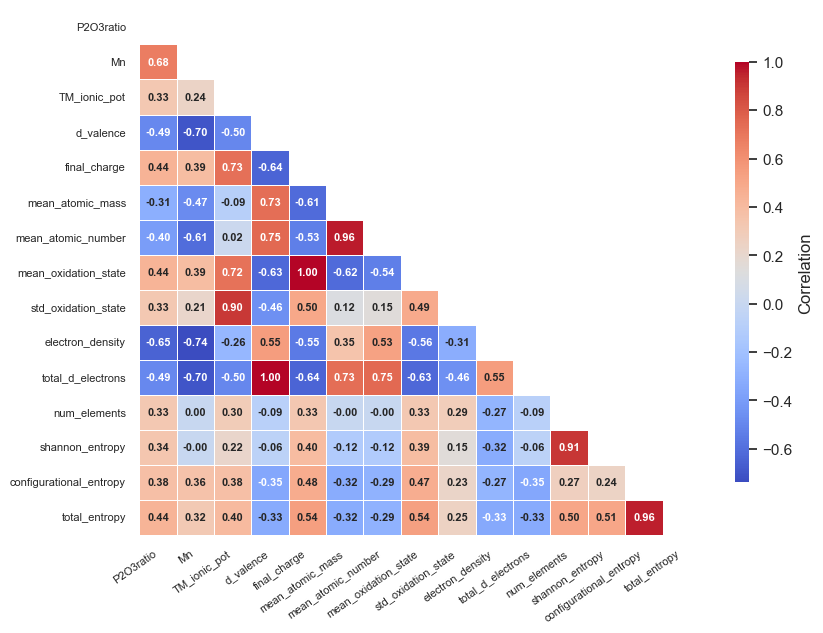

In [22]:
# Calculate correlation matrix on filtered data
corr_matrix = numeric_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Convert cm to inches for figsize
cm_to_inch = 1 / 2.54
fig_width = 22.0 * cm_to_inch
fig_height = 16.5 * cm_to_inch

# Create high-res figure
plt.figure(figsize=(fig_width, fig_height), dpi=100)
sns.set_theme(style="white")

# Plot heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={"shrink": 0.8, "aspect": 30, "label": "Correlation"},
    linewidths=0.5,
    linecolor="white"
)

plt.xticks(rotation=35, ha="right", fontsize=8, weight="medium")
plt.yticks(rotation=0, fontsize=8, weight="medium")

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [24]:
analyzer = ApprOXimate()  # You'll need to initialize this

tm_results = []

for formula in df_exp['Chemical']:
    oximate_str = analyzer.charge_balance(formula, return_format="string")
    comp_dict = parse_approximate_str(oximate_str.split(';FinalChargeBalance:')[0])
    tm_features = extract_tm_features(comp_dict)
    tm_results.append(tm_features)

df_tm_results = pd.DataFrame(tm_results)
df_exp_tm_features = pd.concat([df_exp.reset_index(drop=True), df_tm_results], axis=1)
df_exp_tm_features

C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3484870237.py:55: UserWarning: No default ionic radius for Ni2+. Using ls data.
  weighted_radius = sum(Specie(element, ox).ionic_radius * frac for ox, frac in details) / total_fraction
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3484870237.py:55: UserWarning: No default ionic radius for Ni4+. Using ls data.
  weighted_radius = sum(Specie(element, ox).ionic_radius * frac for ox, frac in details) / total_fraction
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3484870237.py:57: UserWarning: No default ionic radius for Mn4+. Using ls data.
  weighted_radius = Specie(element, details[0][0]).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3484870237.py:57: UserWarning: No default ionic radius for Ni4+. Using ls data.
  weighted_radius = Specie(element, details[0][0]).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3484870237.py:57: UserWarning: No default ionic radius for Ni2+. Using ls data.
  weighted_radi

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,Mn_avg_ox_state,Mn_avg_ionic_radius,Mn_ionic_potential,Mn_ox_state_range,Mn_avg_d_electrons,Ni_avg_ox_state,Ni_avg_ionic_radius,Ni_ionic_potential,Ni_ox_state_range,Ni_avg_d_electrons
0,U00001,NaCuO2,12,950,-1.00,Unsuccessful,1.0,1.000000,2.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U00002,NaFeO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U00003,NaMnO2,12,950,0.80,Successful,1.0,0.000000,2.0,0.000000,...,3.000000,0.785000,3.821656,0.0,4.000000,NaN,NaN,NaN,NaN,NaN
3,U00004,NaNiO2,12,950,-1.00,Unsuccessful,1.0,0.000000,2.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,3.000000,0.725000,4.137931,2.0,7.000000
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.00,Unsuccessful,1.0,0.500000,2.0,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,U00365,Na0.5Cu7/18Ni7/18Fe1/9Mn1/9O2,3,950,-1.00,Unsuccessful,0.5,0.388889,2.0,0.111111,...,7.000000,0.600000,11.666667,0.0,0.000000,4.000000,0.620000,6.451613,0.0,6.000000
365,U00366,Na0.5Fe7/18Mn7/18Cu1/9Ni1/9O2,3,950,0.52,Successful,0.5,0.111111,2.0,0.388889,...,4.285347,0.663342,6.460239,3.0,2.714653,4.000000,0.620000,6.451613,0.0,6.000000
366,U00367,Na0.5Cu7/18Fe7/18Mn1/9Ni1/9O2,3,950,0.00,Successful,0.5,0.388889,2.0,0.388889,...,7.000000,0.600000,11.666667,0.0,0.000000,4.000000,0.620000,6.451613,0.0,6.000000
367,U00368,Na0.5Mn7/18Ni7/18Fe1/9Cu1/9O2,3,950,0.83,Successful,0.5,0.111111,2.0,0.111111,...,4.000000,0.670000,5.970149,0.0,3.000000,3.573265,0.664807,5.374889,2.0,6.426735


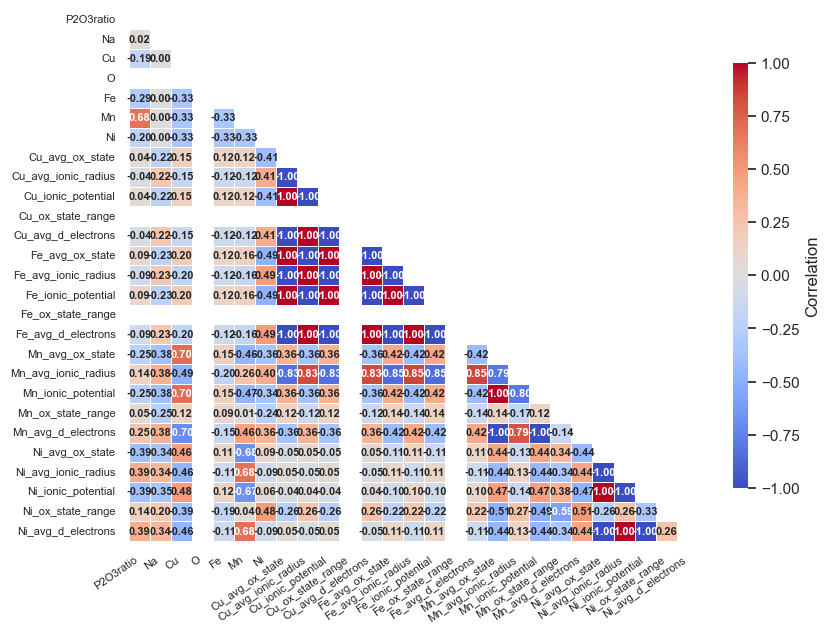

In [25]:
tm_numeric_df = df_exp_tm_features.drop(columns=['Chemical', 'Temperature', 'UID', 'Time', 'Cat_Success'], errors='ignore')

# Calculate correlation matrix on filtered data
corr_matrix = tm_numeric_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Convert cm to inches for figsize
cm_to_inch = 1 / 2.54
fig_width = 22.0 * cm_to_inch
fig_height = 16.5 * cm_to_inch

# Create high-res figure
plt.figure(figsize=(fig_width, fig_height), dpi=100)
sns.set_theme(style="white")

# Plot heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={"shrink": 0.8, "aspect": 30, "label": "Correlation"},
    linewidths=0.5,
    linecolor="white"
)

plt.xticks(rotation=35, ha="right", fontsize=8, weight="medium")
plt.yticks(rotation=0, fontsize=8, weight="medium")

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [26]:
# Save both dataframes with features as separate CSV files
df_exp_features.to_csv("df_exp_features.csv", index=False)
df_exp_tm_features.to_csv("df_exp_tm_features.csv", index=False)

In [40]:
df_exp_mined = pd.read_csv("cleaned_Na_ion.csv")

parsed = df_exp_mined["Chemical"].apply(parse_formula)

# Convert the list of dicts to a DataFrame
parsed_df = pd.DataFrame(parsed.tolist()).fillna(0)

# Combine with original DataFrame
df_exp_mined = pd.concat([df_exp_mined, parsed_df], axis=1)
df_exp_mined

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,Zn,Si,Zr,Li,Co,V,Cr,Sn,Sb,Sc
0,U00001,NaCuO2,12,950,-1.0,Unsuccessful,1.0,1.0,2.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,U00002,NaFeO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,U00003,NaMnO2,12,950,0.8,Successful,1.0,0.0,2.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,U00004,NaNiO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.0,Unsuccessful,1.0,0.5,2.0,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,D00204,NaNi0.4Mn0.4Fe0.2O2,12,900,0.0,Successful,1.0,0.0,2.0,0.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573,D00205,NaNi0.38Mn0.38Fe0.19Ti0.05O2,12,900,0.0,Successful,1.0,0.0,2.0,0.19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574,D00206,NaNi0.36Mn0.36Fe0.18Ti0.1O2,12,900,0.0,Successful,1.0,0.0,2.0,0.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
575,D00207,NaNi0.34Mn0.34Fe0.17Ti0.15O2,12,900,0.0,Successful,1.0,0.0,2.0,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
analyzer = ApprOXimate()

results = []

for formula in df_exp_mined['Chemical']:
    try:
        oximate_str = analyzer.charge_balance(formula, return_format="string")
        features = extract_all_features(formula, oximate_str)
        results.append(features)
    except Exception as e:
        print(f"Error processing {formula}: {e}")
        # Ensure we append a dict of NaNs with same keys as features
        if len(results) > 0:
            nan_features = {key: np.nan for key in results[0].keys()}
        else:
            # If it fails on the very first entry, make a generic dict
            nan_features = {"error": np.nan}
        results.append(nan_features)

df_results = pd.DataFrame(results)
df_exp_mined_features = pd.concat([df_exp_mined.reset_index(drop=True), df_results], axis=1)

C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No default ionic radius for Ni2+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No default ionic radius for Ni4+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:115: UserWarning: No default ionic radius for Ni2+. Using ls data.
  radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:115: UserWarning: No default ionic radius for Ni4+. Using ls data.
  radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:272: UserWarning: No default ionic radius for Ni2+. Using ls data.
  weighted_radius = sum(Specie(element, ox_state).ionic_radius * frac
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:272: UserWarning: No default ionic radius

Error processing Na0.82Fe0.41Mn0.43Ti0.09Si0.07O2: unsupported operand type(s) for /: 'int' and 'NoneType'
Error processing Na0.76Ni0.20Mn0.42Fe0.30Mg0.04Ti0.015Zr0.025O2: 'NoneType' object has no attribute 'split'


C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No default ionic radius for Cr3+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:115: UserWarning: No default ionic radius for Cr3+. Using ls data.
  radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:280: UserWarning: No default ionic radius for Cr3+. Using ls data.
  radius = Specie(element, ox_state).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:447: UserWarning: No default ionic radius for Cr3+. Using ls data.
  avg_radius = Specie(el, ox).ionic_radius
C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\2328320923.py:79: UserWarning: No ionic radius for Sc0+!
  radius = Specie(element, ox_state).ionic_radius


Error processing Na0.67Sc0.1Ni0.23Mn0.67O2: unsupported operand type(s) for /: 'int' and 'NoneType'
Error processing Na0.67Ni0.285Mn0.475Fe0.19Zr0.05O2: 'NoneType' object has no attribute 'split'
Error processing Na0.67Ni0.275Mn0.4625Fe0.185Zr0.075O2: 'NoneType' object has no attribute 'split'
Error processing Na0.67Ni0.27Mn0.45Fe0.18Zr0.1O2: 'NoneType' object has no attribute 'split'


In [42]:
# Find NaN rows where features were not extracted
df_exp_mined_features

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,electron_density,total_d_electrons,total_f_electrons,num_elements,shannon_entropy,configurational_entropy,total_entropy,atomic_packing_parameter,mean_coordination_number,atomic_radii_vmr
0,U00001,NaCuO2,12,950,-1.0,Unsuccessful,1.0,1.0,2.0,0.00,...,0.480872,9.00,0.0,3.0,1.039721,0.000000,1.039721,6.513727,11.00,0.019722
1,U00002,NaFeO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,1.00,...,0.478194,5.00,0.0,3.0,1.039721,0.000000,1.039721,6.330712,10.50,0.030692
2,U00003,NaMnO2,12,950,0.8,Successful,1.0,0.0,2.0,0.00,...,0.473043,4.00,0.0,3.0,1.039721,0.000000,1.039721,6.330712,10.50,0.030692
3,U00004,NaNiO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,0.00,...,0.483806,7.00,0.0,3.0,1.039721,0.693147,1.732868,6.223208,10.50,0.040284
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.0,Unsuccessful,1.0,0.5,2.0,0.50,...,0.479578,7.00,0.0,4.0,1.213008,0.000000,1.213008,6.422219,10.75,0.025195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,D00204,NaNi0.4Mn0.4Fe0.2O2,12,900,0.0,Successful,1.0,0.0,2.0,0.20,...,0.478451,5.40,0.0,5.0,1.303451,0.000000,1.303451,6.290951,10.70,0.036049
573,D00205,NaNi0.38Mn0.38Fe0.19Ti0.05O2,12,900,0.0,Successful,1.0,0.0,2.0,0.19,...,0.478356,5.18,0.0,6.0,1.339893,0.389377,1.729270,6.297554,10.69,0.034991
574,D00206,NaNi0.36Mn0.36Fe0.18Ti0.1O2,12,900,0.0,Successful,1.0,0.0,2.0,0.18,...,0.478260,4.96,0.0,6.0,1.358349,0.590842,1.949191,6.304574,10.68,0.033974
575,D00207,NaNi0.34Mn0.34Fe0.17Ti0.15O2,12,900,0.0,Successful,1.0,0.0,2.0,0.17,...,0.478164,4.74,0.0,6.0,1.369569,0.686211,2.055779,6.312097,10.67,0.033005


In [43]:
nan_rows = df_exp_mined_features[df_exp_mined_features.isna().any(axis=1)]
nan_rows

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,electron_density,total_d_electrons,total_f_electrons,num_elements,shannon_entropy,configurational_entropy,total_entropy,atomic_packing_parameter,mean_coordination_number,atomic_radii_vmr
379,D00011,Na0.82Fe0.41Mn0.43Ti0.09Si0.07O2,12,900,1.00,Successful,0.82,0.0,2.0,0.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
386,D00018,Na0.76Ni0.20Mn0.42Fe0.30Mg0.04Ti0.015Zr0.025O2,24,950,0.18,Successful,0.76,0.0,2.0,0.300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,D00193,Na0.67Sc0.1Ni0.23Mn0.67O2,10,900,1.00,Successful,0.67,0.0,2.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,D00201,Na0.67Ni0.285Mn0.475Fe0.19Zr0.05O2,12,900,1.00,Successful,0.67,0.0,2.0,0.190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,D00202,Na0.67Ni0.275Mn0.4625Fe0.185Zr0.075O2,12,900,1.00,Successful,0.67,0.0,2.0,0.185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,D00203,Na0.67Ni0.27Mn0.45Fe0.18Zr0.1O2,12,900,1.00,Successful,0.67,0.0,2.0,0.180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_exp_mined_features.drop(nan_rows.index, inplace=True)
df_exp_mined_features

,UID,Chemical,Time,Temperature,P2O3ratio,Cat_Success,Na,Cu,O,Fe,...,electron_density,total_d_electrons,total_f_electrons,num_elements,shannon_entropy,configurational_entropy,total_entropy,atomic_packing_parameter,mean_coordination_number,atomic_radii_vmr
0,U00001,NaCuO2,12,950,-1.0,Unsuccessful,1.0,1.0,2.0,0.00,...,0.480872,9.00,0.0,3.0,1.039721,0.000000,1.039721,6.513727,11.00,0.019722
1,U00002,NaFeO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,1.00,...,0.478194,5.00,0.0,3.0,1.039721,0.000000,1.039721,6.330712,10.50,0.030692
2,U00003,NaMnO2,12,950,0.8,Successful,1.0,0.0,2.0,0.00,...,0.473043,4.00,0.0,3.0,1.039721,0.000000,1.039721,6.330712,10.50,0.030692
3,U00004,NaNiO2,12,950,-1.0,Unsuccessful,1.0,0.0,2.0,0.00,...,0.483806,7.00,0.0,3.0,1.039721,0.693147,1.732868,6.223208,10.50,0.040284
4,U00005,NaCu0.5Fe0.5O2,12,950,-1.0,Unsuccessful,1.0,0.5,2.0,0.50,...,0.479578,7.00,0.0,4.0,1.213008,0.000000,1.213008,6.422219,10.75,0.025195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,D00204,NaNi0.4Mn0.4Fe0.2O2,12,900,0.0,Successful,1.0,0.0,2.0,0.20,...,0.478451,5.40,0.0,5.0,1.303451,0.000000,1.303451,6.290951,10.70,0.036049
573,D00205,NaNi0.38Mn0.38Fe0.19Ti0.05O2,12,900,0.0,Successful,1.0,0.0,2.0,0.19,...,0.478356,5.18,0.0,6.0,1.339893,0.389377,1.729270,6.297554,10.69,0.034991
574,D00206,NaNi0.36Mn0.36Fe0.18Ti0.1O2,12,900,0.0,Successful,1.0,0.0,2.0,0.18,...,0.478260,4.96,0.0,6.0,1.358349,0.590842,1.949191,6.304574,10.68,0.033974
575,D00207,NaNi0.34Mn0.34Fe0.17Ti0.15O2,12,900,0.0,Successful,1.0,0.0,2.0,0.17,...,0.478164,4.74,0.0,6.0,1.369569,0.686211,2.055779,6.312097,10.67,0.033005


In [45]:
df_exp_mined_features = df_exp_mined_features[df_exp_mined_features['Cat_Success'] == "Successful"]
df_exp_mined_features.drop(columns=['Cat_Success'], inplace=True, errors='ignore')

C:\Users\fayat\AppData\Local\Temp\ipykernel_9556\3828012779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp_mined_features.drop(columns=['Cat_Success'], inplace=True, errors='ignore')


In [46]:
df_exp_mined_features

,UID,Chemical,Time,Temperature,P2O3ratio,Na,Cu,O,Fe,Mn,...,electron_density,total_d_electrons,total_f_electrons,num_elements,shannon_entropy,configurational_entropy,total_entropy,atomic_packing_parameter,mean_coordination_number,atomic_radii_vmr
2,U00003,NaMnO2,12,950,0.80,1.0,0.000000,2.0,0.000000,1.000000,...,0.473043,4.000,0.0,3.0,1.039721,0.000000,1.039721,6.330712,10.500000,0.030692
5,U00006,NaCu0.5Mn0.5O2,12,950,1.00,1.0,0.500000,2.0,0.000000,0.500000,...,0.472728,6.000,0.0,4.0,1.213008,0.000000,1.213008,6.326415,10.750000,0.034960
7,U00008,NaFe0.5Mn0.5O2,12,950,1.00,1.0,0.000000,2.0,0.500000,0.500000,...,0.475629,4.500,0.0,4.0,1.213008,0.000000,1.213008,6.330712,10.500000,0.030692
9,U00010,NaMn0.5Ni0.5O2,12,950,1.00,1.0,0.000000,2.0,0.000000,0.500000,...,0.478515,5.500,0.0,4.0,1.213008,0.000000,1.213008,6.426807,10.750000,0.035363
10,U00011,NaCu1/3Fe1/3Mn1/3O2,12,950,0.75,1.0,0.333333,2.0,0.333333,0.333333,...,0.474548,5.661,0.0,5.0,1.314081,0.000000,1.314081,6.328926,10.667667,0.033512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,D00204,NaNi0.4Mn0.4Fe0.2O2,12,900,0.00,1.0,0.000000,2.0,0.200000,0.400000,...,0.478451,5.400,0.0,5.0,1.303451,0.000000,1.303451,6.290951,10.700000,0.036049
573,D00205,NaNi0.38Mn0.38Fe0.19Ti0.05O2,12,900,0.00,1.0,0.000000,2.0,0.190000,0.380000,...,0.478356,5.180,0.0,6.0,1.339893,0.389377,1.729270,6.297554,10.690000,0.034991
574,D00206,NaNi0.36Mn0.36Fe0.18Ti0.1O2,12,900,0.00,1.0,0.000000,2.0,0.180000,0.360000,...,0.478260,4.960,0.0,6.0,1.358349,0.590842,1.949191,6.304574,10.680000,0.033974
575,D00207,NaNi0.34Mn0.34Fe0.17Ti0.15O2,12,900,0.00,1.0,0.000000,2.0,0.170000,0.340000,...,0.478164,4.740,0.0,6.0,1.369569,0.686211,2.055779,6.312097,10.670000,0.033005


In [47]:
df_exp_mined_features.to_csv("df_exp_mined_features.csv", index=False)